## Try different Boosting models to get better predictions

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    7614 non-null   int64  
 1   bed             7614 non-null   float64
 2   bath            7614 non-null   float64
 3   acre_lot        7614 non-null   float64
 4   zip_code        7614 non-null   float64
 5   house_size      7614 non-null   float64
 6   prev_sold_date  7614 non-null   object 
 7   price           7614 non-null   float64
 8   prev_sold_year  7614 non-null   int64  
 9   zip_code_str    7614 non-null   int64  
 10  latitude        7614 non-null   float64
 11  longitude       7614 non-null   float64
 12  county          7614 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 773.4+ KB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,0,3.0,2.0,0.14,7001.0,1542.0,2022-01-27,305100.0,2022,7001,40.582316,-74.271506,12
1,1,3.0,2.0,0.11,7001.0,1500.0,2016-12-21,479000.0,2016,7001,40.582316,-74.271506,12
2,2,3.0,2.0,0.17,7001.0,7501.0,2021-11-01,340000.0,2021,7001,40.582316,-74.271506,12
3,3,5.0,2.0,0.18,7001.0,1387.0,2020-12-22,484000.0,2020,7001,40.582316,-74.271506,12
4,4,3.0,2.0,0.17,7001.0,1500.0,2019-05-28,425000.0,2019,7001,40.582316,-74.271506,12


#### Create an object to pass to the function that will normalize the data

In [5]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
7609,1.488841,1.569459,0.024249,-0.289298,-0.122074,2017,40.594266,-75.096659,8848.0
7610,0.594761,0.570390,0.157168,-0.289298,-0.060054,2016,40.514169,-75.027112,8825.0
7611,-0.299318,-0.428678,-0.059088,-0.289298,-0.087343,2021,40.848398,-74.160266,7012.0
7612,-0.299318,0.570390,-0.058033,-0.289298,-0.010439,2022,40.848398,-74.160266,7012.0
7613,0.594761,0.570390,-0.060143,-0.289298,0.460910,2016,40.991681,-73.980202,7640.0


#### Create a variable for the correlation of the normalized data

In [6]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.037860
bed               0.413451
bath              0.584847
house_size        0.337901
prev_sold_year    0.039367
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

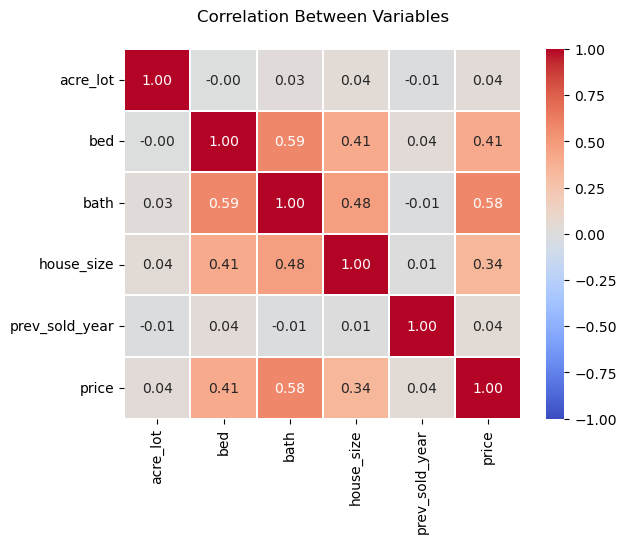

In [7]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [8]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [9]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [10]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [11]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [12]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Ada Boosting

In [13]:
adaboost = dosomething("Ada Boost","Ada Boost", normalize_df, features, "price")
results_dict_append(adaboost["results"])
adaboost_predict = adaboost["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Ada Boost EVS = 0.458110765
Ada Boost MSE = 0.632462
Ada Boost MAE = 0.598454
Ada Boost R2 = 0.361424
Ada Boost Fit Time = 0.07492728233337402


#### Gradient Boosting

In [14]:
gbr = dosomething("Gradient Boosting","Gradient Boosting", normalize_df, features, "price")
results_dict_append(gbr["results"])
gbr_predict = gbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Gradient Boosting EVS = 0.610032567
Gradient Boosting MSE = 0.386768
Gradient Boosting MAE = 0.374979
Gradient Boosting R2 = 0.609493
Gradient Boosting Fit Time = 0.3388947010040283


#### Hist Gradient Boosting

In [15]:
histgbr = dosomething("Hist Gradient Boosting","Hist Gradient Boosting", normalize_df, features, "price")
results_dict_append(histgbr["results"])
histgbr_predict = histgbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Hist Gradient Boosting EVS = 0.696329826
Hist Gradient Boosting MSE = 0.301281
Hist Gradient Boosting MAE = 0.322916
Hist Gradient Boosting R2 = 0.695806
Hist Gradient Boosting Fit Time = 0.4961361885070801


#### Random Forest

In [16]:
rf = dosomething("Random Forest","Random Forest", normalize_df, features, "price")
results_dict_append(rf["results"])
rf_predict = rf["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Random Forest EVS = 0.639962410
Random Forest MSE = 0.357106
Random Forest MAE = 0.343331
Random Forest R2 = 0.639442
Random Forest Fit Time = 1.9210086822509767


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rf_predict_df = pd.DataFrame(rf_predict).reset_index()
rf_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

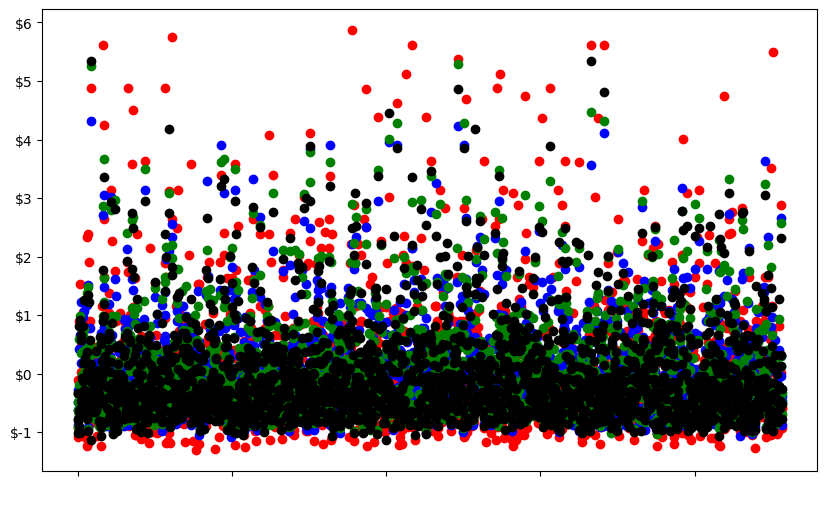

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(adaboost_predict_df.index,adaboost_predict_df["prediction"], color="black")
plt.scatter(rf_predict_df.index,rf_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Ada Boost',
  'Gradient Boosting',
  'Hist Gradient Boosting',
  'Random Forest'],
 'explained variance score': ['0.458110765',
  '0.610032567',
  '0.696329826',
  '0.639962410'],
 'mae score': ['0.598454', '0.374979', '0.322916', '0.343331'],
 'mse score': ['0.632462', '0.386768', '0.301281', '0.357106'],
 'r2 score': ['0.361424', '0.609493', '0.695806', '0.639442'],
 'mean fit time': [0.07492728233337402,
  0.3388947010040283,
  0.4961361885070801,
  1.9210086822509767]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost,0.458110765,0.598454,0.632462,0.361424,0.074927
Gradient Boosting,0.610032567,0.374979,0.386768,0.609493,0.338895
Hist Gradient Boosting,0.696329826,0.322916,0.301281,0.695806,0.496136
Random Forest,0.639962410,0.343331,0.357106,0.639442,1.921009


In [22]:
tohtml = model_comparisons.to_html()
#tohtml